<b style='font-size:2em'>Tutorial 1 – Grids and fields</b>

This first part of the tutorial introduces grids and fields. Grids define the space on which fields are discretized. These fields then describe the state of the partial differential equations.

In [1]:
# import the package
import numpy as np
import pde

## Basic grids

We start by defining the space and its discretization. The simplest variant is a rectangular geometry with unit-sized cells, which we call a `UnitGrid`. Cells with unequal sizes are supported by the more complex `CartesianGrid`. Finally, we support a small set of curvilinear (yet still orthogonal) coordinate systems: `PolarGrid` on a disk, `SphericalGrid` in a ball, and `CylindricalGrid` in an axisymmetric cylinder. All these grids have in common that they assume that fields do not depend on the angular variables, i.e., they enforce symmetry.

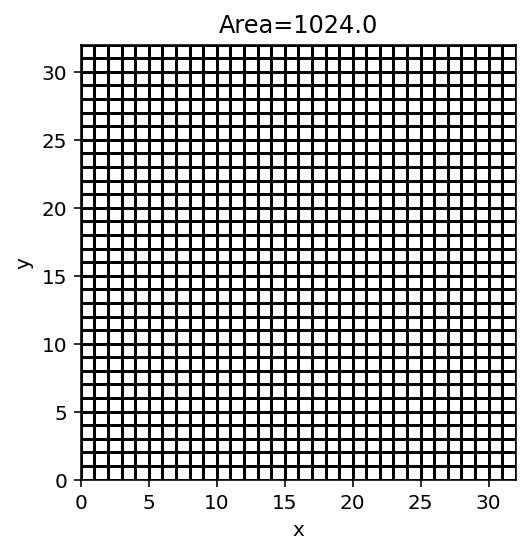

In [2]:
grid = pde.UnitGrid([32, 32])
grid.plot(title=f'Area={grid.volume}')

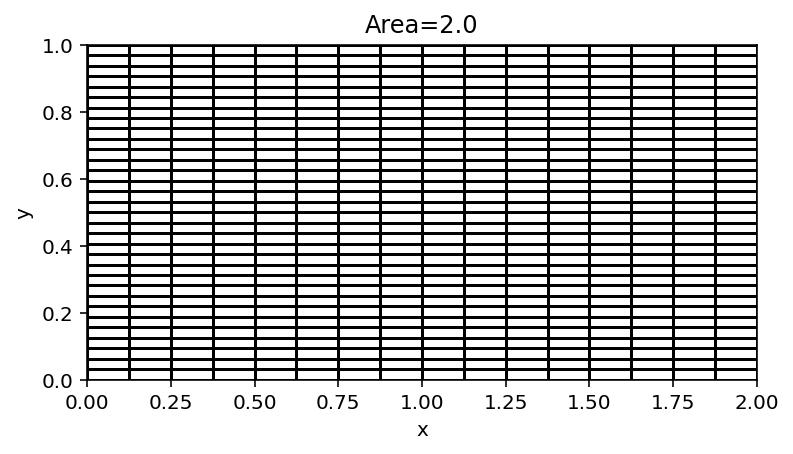

In [3]:
grid = pde.CartesianGrid([[0, 2], [0, 1]], [16, 32])
grid.plot(title=f'Area={grid.volume}')

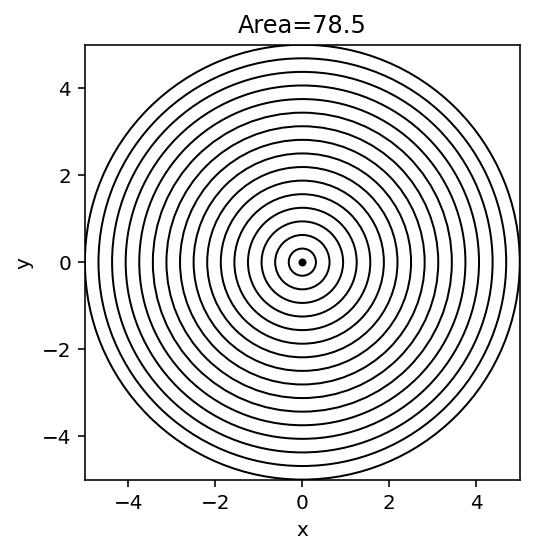

In [4]:
grid = pde.PolarGrid(5, 16)
grid.plot(title=f'Area={grid.volume:.3g}')

`PolarGrid` and `SphericalGrid` also support annuli. The two radii can be specified by a supplying a tuple to the `radius` argument.

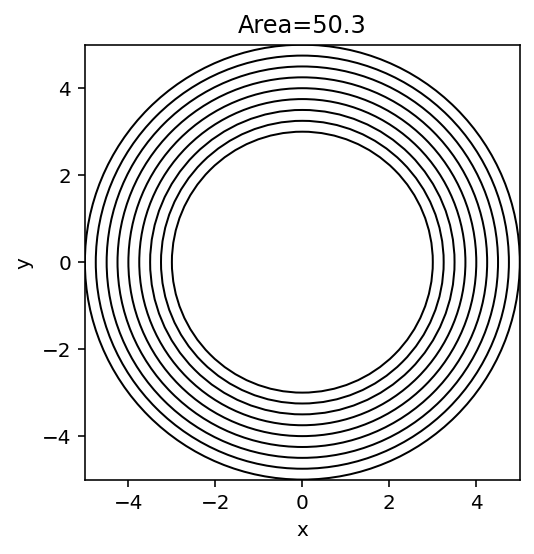

In [5]:
grid = pde.PolarGrid((3, 5), 8)
grid.plot(title=f'Area={grid.volume:.3g}')

## Scalar fields
Scalar fields represent scalar quantities that depend on position. In this package, scalar fields are represented by their values at the support points of the discretized grids discussed above. Consequently, one first has to construct a grid and pass it to the `ScalarField` class to construct a scalar field.

In [6]:
grid = pde.CartesianGrid([[0, 4*np.pi], [0, 2*np.pi]], [128, 32])

field = pde.ScalarField(grid, data=1)
field.data

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Scalar fields support a range of mathematical operations and can thus roughly used like bare numpy arrays. The actual underlying data of the field is accessed by its `.data` attribute.

In [7]:
field += 4
field.data

array([[5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.]])

Instead of looking at the raw data, fields will be most often visualized in plots. A convenient plotting method is the `.plot()` method.

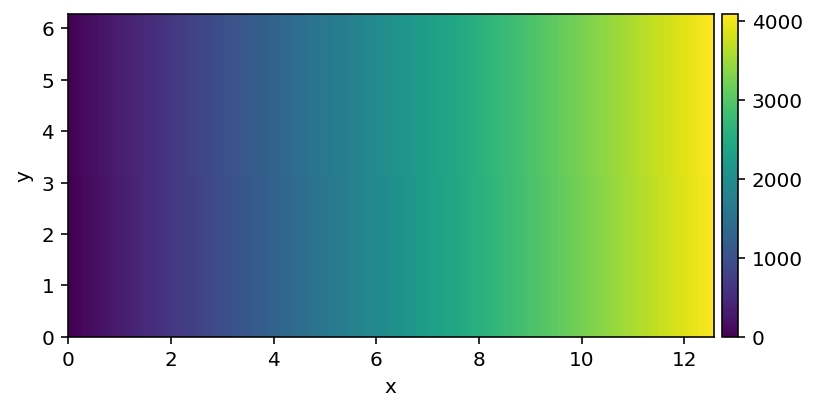

In [8]:
grid = pde.CartesianGrid([[0, 4*np.pi], [0, 2*np.pi]], [128, 32])
data = np.arange(128 * 32).reshape(grid.shape)
field = pde.ScalarField(grid, data=data)
field.plot(colorbar=True);

Values at individual points can be determined by interpolation

In [9]:
field.interpolate([2.1, 0.3])

array(669.5214667)

There are a range of methods to initialize scalar fields. For instance, various random fields can be initiated using the `ScalarField.random_*()` methods.

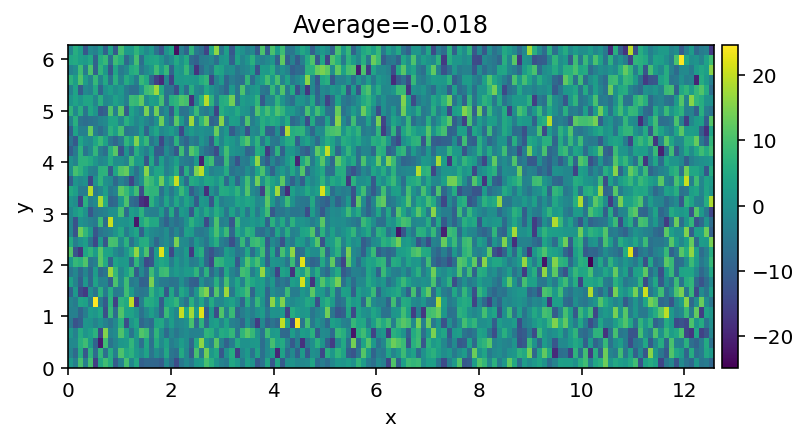

In [10]:
field = pde.ScalarField.random_normal(grid)
field.plot(title=f'Average={field.average:.3f}', colorbar=True);

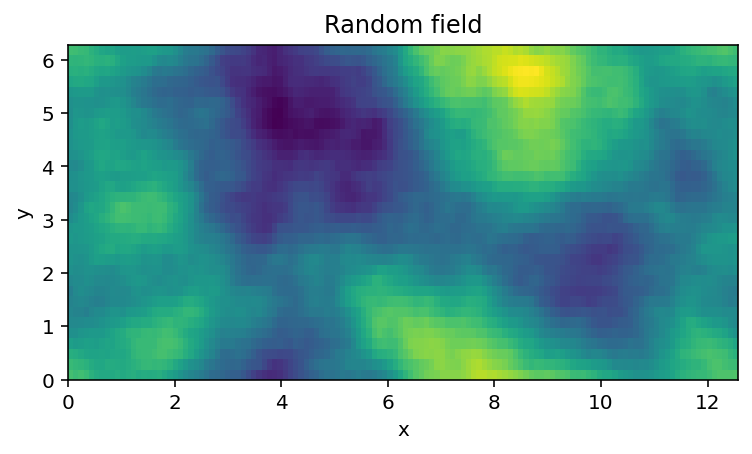

In [11]:
field = pde.ScalarField.random_colored(grid, exponent=-4, label='Random field')
field.plot();

Fields can be written to files using the optional `h5py` package to write the data in the Hierarchical Data Format (HDF). Note that the underlying grid is also stored in the file and recreated transparently when the file is read using the `ScalarField.from_file()` method.

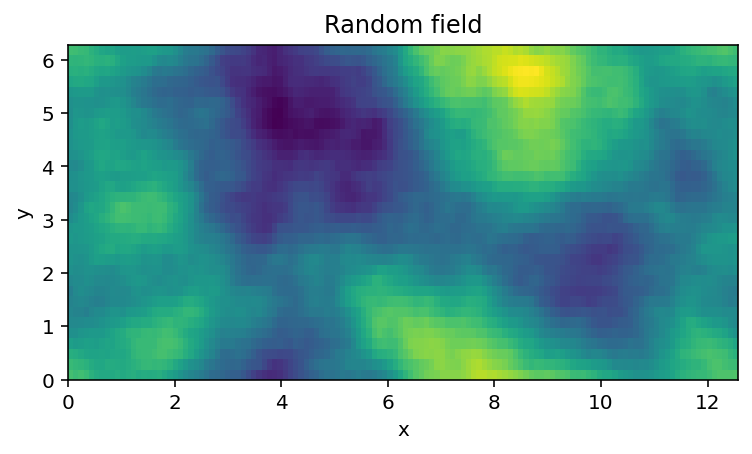

In [12]:
field.to_file('random_field.hdf')

field_loaded = pde.ScalarField.from_file('random_field.hdf')
field_loaded.plot();

Fields can be further analyzed by slicing or projeting them along given axes. Slicing uses interpolation to calculate field values at positions that might not lie on the original grid. In contrast, projecting integrates over the given axes, which are thereby removed.

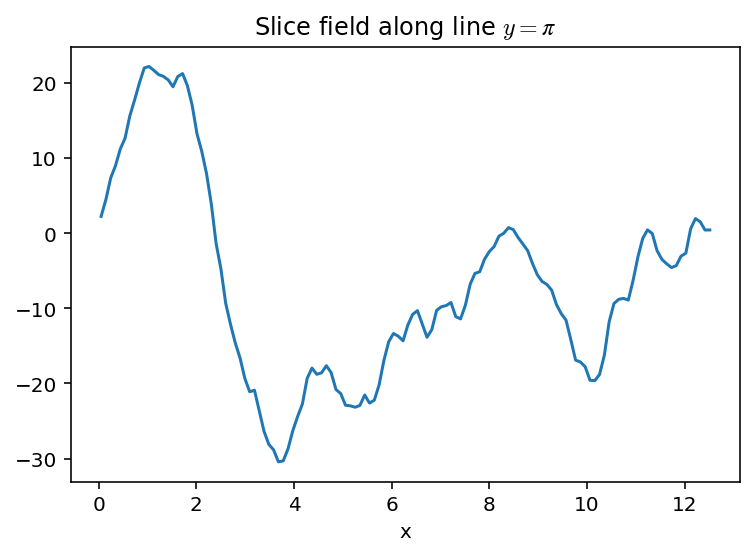

In [13]:
slice_x = field.slice({'y': np.pi})
slice_x.plot(title='Slice field along line $y=π$');

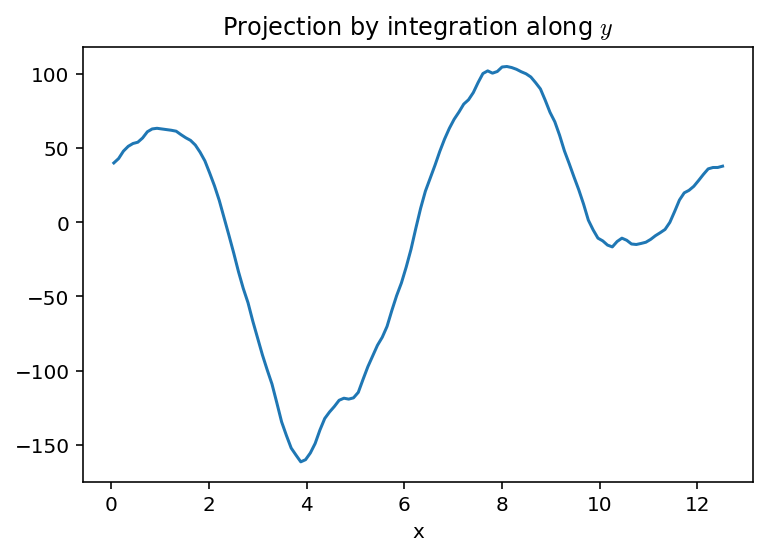

In [14]:
project_x = field.project('y')
project_x.plot(title='Projection by integration along $y$');

Finally, fields can also be created from mathematical expressions that are parsed using `sympy`. Note that this general method is unsafe to process user-supplied data, since it uses the `exec` function.

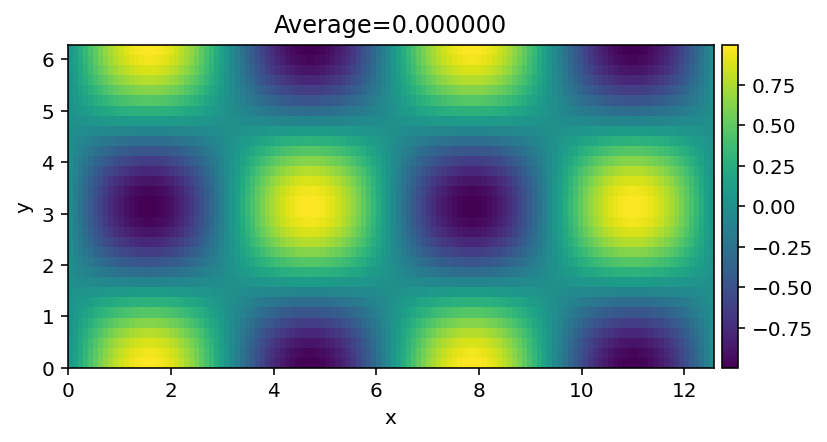

In [15]:
field = pde.ScalarField.from_expression(grid, 'sin(x) * cos(y)')
field.plot(title=f'Average={field.average:f}', colorbar=True);

## Differential operators for scalar fields
Various differential operators can be applied to fields. These differential operators are just-in-time compiled using `numba`. Consequently, their first evaluation can take quite long, since code needs to be analyzed and compiled. However, each subsequent evaluation will be very fast.

Note that differential operators require boundary conditions to be well-defined. Boundary conditions can be specified in a variety of formats, as shown by some examples below. More information on the various formats can be found in <a href="https://py-pde.readthedocs.io/en/latest/packages/pde.grids.boundaries.html#boundary-conditions">the documentation</a>.

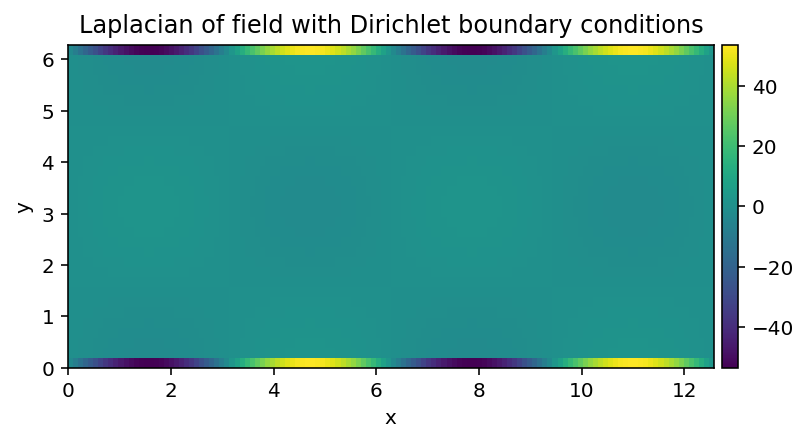

In [16]:
grid = pde.CartesianGrid([[0, 4*np.pi], [0, 2*np.pi]], [128, 32])
field = pde.ScalarField.from_expression(grid, 'sin(x) * cos(y)')

laplace_dir = field.laplace({'value': 0})
laplace_dir.plot(title='Laplacian of field with Dirichlet boundary conditions', colorbar=True);

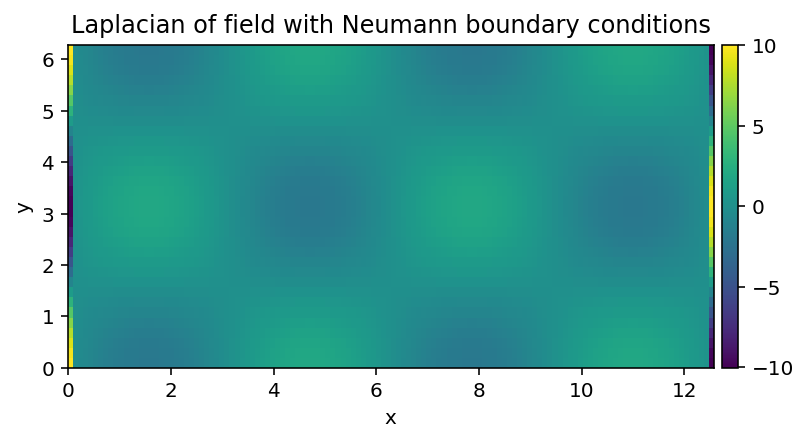

In [17]:
laplace_neu = field.laplace({'derivative': 0})
laplace_neu.plot(title='Laplacian of field with Neumann boundary conditions', colorbar=True);

Note that the Laplace operator results in large values at the boundary where the supplied boundary condition is incompatible with the actual field data. In this case, this can be fixed by imposing Dirichlet conditions along the $x$-axis and Neumann conditions along the $y$-axis:

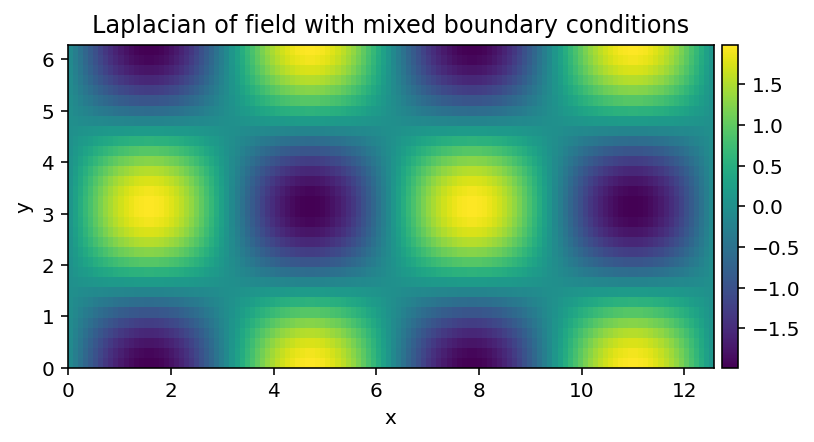

In [18]:
laplace_mix = field.laplace([{'value': 0}, {'derivative': 0}])
laplace_mix.plot(title='Laplacian of field with mixed boundary conditions', colorbar=True);

Alternatively, the Laplace operator can be evaluate assuming periodic boundary conditions. Note that periodic boundary conditions are a special case of boundary conditions, since they also affect how distances are measured in the defined space. Consequently, periodic boundary conditions need to be already declared on the grid instance.

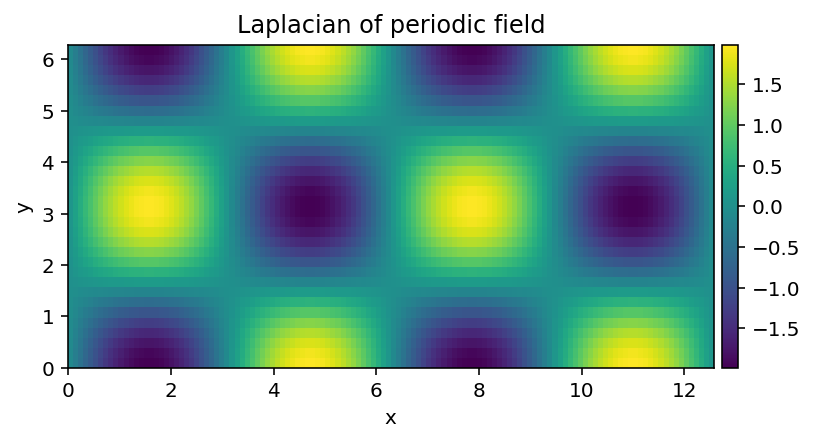

In [19]:
grid_per = pde.CartesianGrid([[0, 4*np.pi], [0, 2*np.pi]], [128, 32], periodic=True)
field_per = pde.ScalarField.from_expression(grid_per, 'sin(x) * cos(y)')
laplace_per = field_per.laplace('periodic')
laplace_per.plot(title='Laplacian of periodic field', colorbar=True);

Periodic and non-periodic axes can also be mixed as in the example below. In this case, the $x$-axis is periodic and thus requires periodic boundary conditions. Conversely, the $y$-axis is non-periodic and any other boundary condition can be specified. The most generic one is a Neumann condition of vanishing derivative. For convenience, we also define `natural` boundary conditions, which indicate periodic conditions for periodic axes and Neumann conditions otherwise.

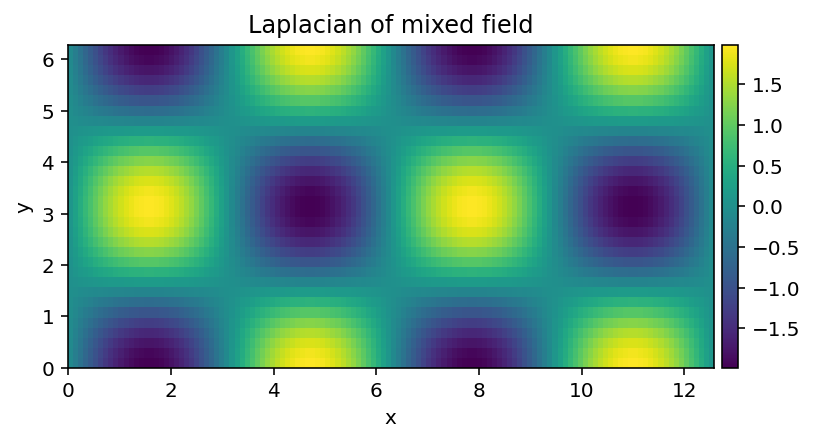

In [20]:
grid_mixed = pde.CartesianGrid([[0, 4*np.pi], [0, 2*np.pi]], [128, 32], periodic=[True, False])
field_mixed = pde.ScalarField.from_expression(grid_mixed, 'sin(x) * cos(y)')

laplace_mixed = field_mixed.laplace(['periodic', {'derivative': 0}])
# laplace_mixed = field_mixed.laplace('natural')
laplace_mixed.plot(title='Laplacian of mixed field', colorbar=True);

## Vector and tensor fields
Vector and tensor fields appear often in physical equations, e.g., due to applied differential operators. They offer almost all the methods already introduced for scalar fields above.

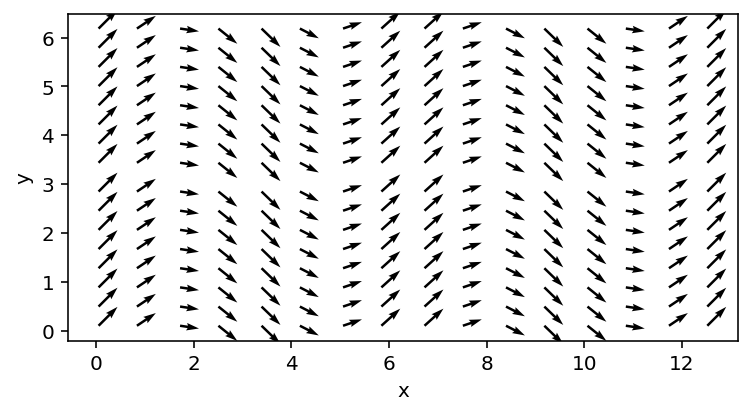

In [21]:
grid_per = pde.CartesianGrid([[0, 4*np.pi], [0, 2*np.pi]], [128, 32], periodic=True)
vector_field = pde.VectorField.from_expression(grid_per, ['1', 'cos(x)'])
vector_field.plot();

Vector fields can also originate from differential operators

In [22]:
field_per = pde.ScalarField.from_expression(grid_per, 'sin(x) * cos(y)')
field_grad = field_per.gradient('natural')
field_grad

VectorField(grid=CartesianGrid(bounds=((0.0, 12.566370614359172), (0.0, 6.283185307179586)), shape=(128, 32), periodic=[True, True]), data=[[[ 0.99239003  0.95425304  0.87944464 ...  0.87944464  0.95425304
    0.99239003]
  [ 0.98283277  0.94506306  0.87097511 ...  0.87097511  0.94506306
    0.98283277]
  [ 0.9638103   0.92677161  0.85411761 ...  0.85411761  0.92677161
    0.9638103 ]
  ...
  [ 0.9638103   0.92677161  0.85411761 ...  0.85411761  0.92677161
    0.9638103 ]
  [ 0.98283277  0.94506306  0.87097511 ...  0.87097511  0.94506306
    0.98283277]
  [ 0.99239003  0.95425304  0.87944464 ...  0.87944464  0.95425304
    0.99239003]]

 [[-0.00477863 -0.01415225 -0.022982   ...  0.022982    0.01415225
    0.00477863]
  [-0.01428987 -0.04232045 -0.06872468 ...  0.06872468  0.04232045
    0.01428987]
  [-0.02366349 -0.07008108 -0.1138055  ...  0.1138055   0.07008108
    0.02366349]
  ...
  [ 0.02366349  0.07008108  0.1138055  ... -0.1138055  -0.07008108
   -0.02366349]
  [ 0.01428987  0

In [23]:
field_grad.average

array([ 6.49503778e-19, -4.80948622e-19])

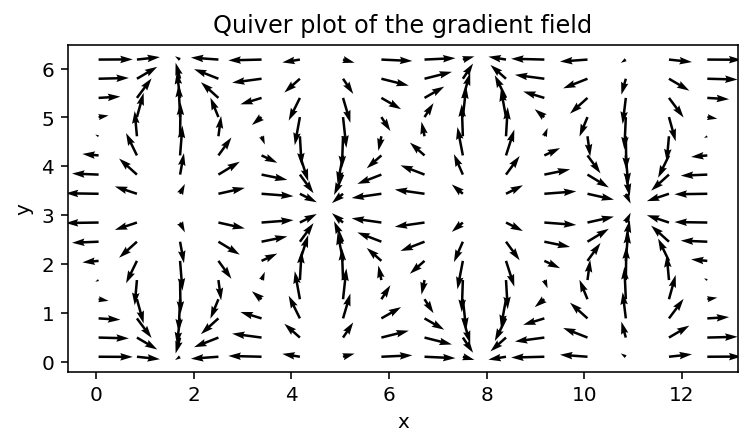

In [24]:
res = field_grad.plot(method='quiver', title='Quiver plot of the gradient field');

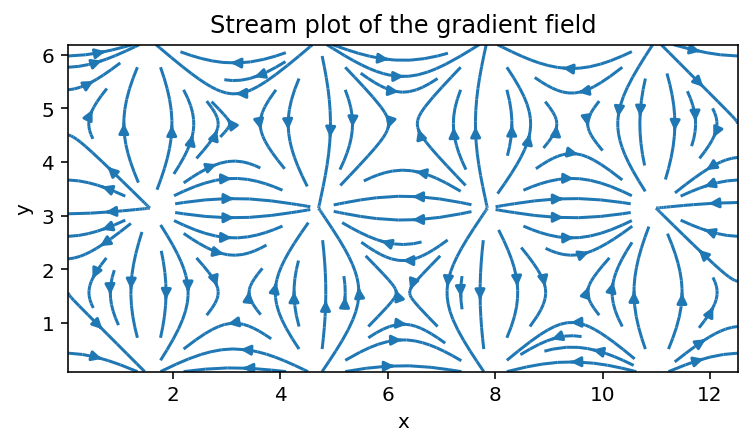

In [25]:
field_grad.plot(method='streamplot', title='Stream plot of the gradient field');

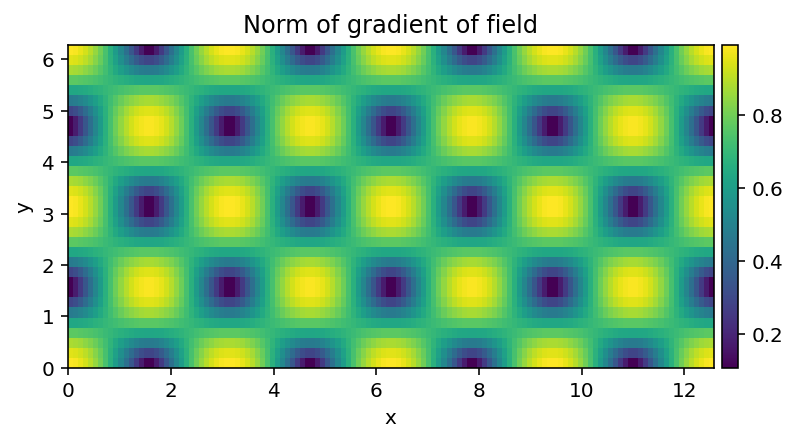

In [26]:
gradient_norm = field_grad.to_scalar('norm')
gradient_norm.plot(title='Norm of gradient of field', colorbar=True);

Individual components can be extracted by subscripting.

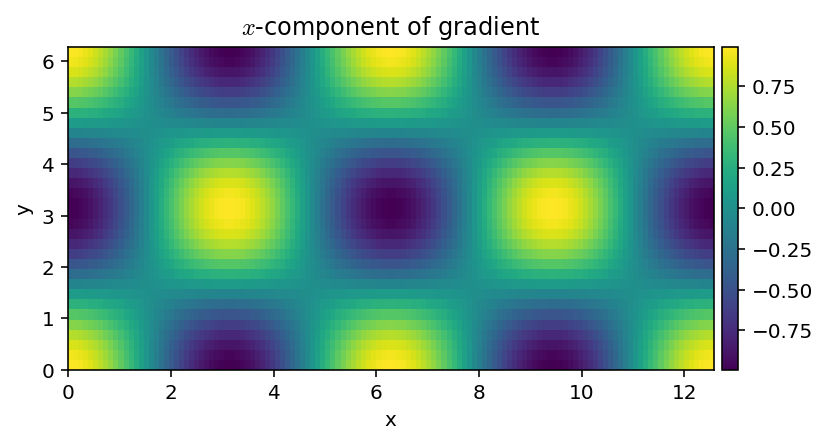

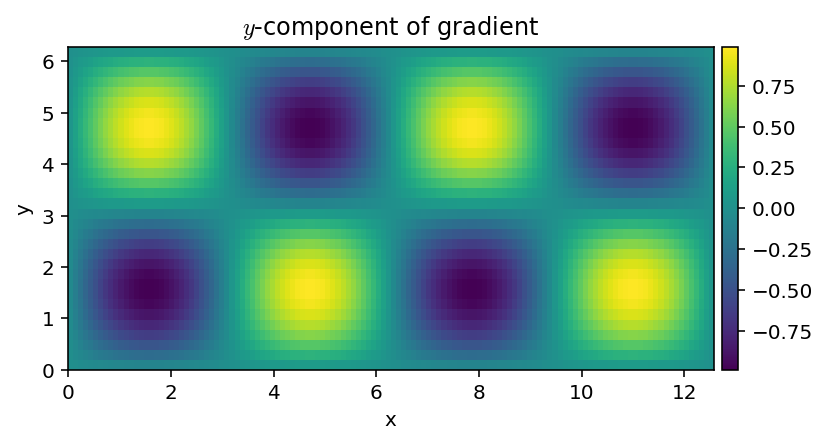

In [27]:
comp_x = field_grad[0]
comp_y = field_grad[1]
comp_x.plot(title='$x$-component of gradient', colorbar=True);
comp_y.plot(title='$y$-component of gradient', colorbar=True);

This can be helpful to calculate quantities component-wise.

In [28]:
gradient_expl_norm = (comp_x**2 + comp_y**2)**0.5
np.allclose(gradient_expl_norm.data, gradient_norm.data)

True

Scalar and vector fields can be interpreted as fields of rank 0 and 1, respectively. The package also supports rank-2 tensors, which are represented by `Tensor2Field`. Such a tensorial field can also originate from differential operators, e.g., as a Hessian.

In [29]:
field_hess = field_grad.gradient('natural', label='Hessian of field')
field_hess.attributes

{'class': 'Tensor2Field',
 'grid': CartesianGrid(bounds=((0.0, 12.566370614359172), (0.0, 6.283185307179586)), shape=(128, 32), periodic=[True, True]),
 'label': 'Hessian of field'}

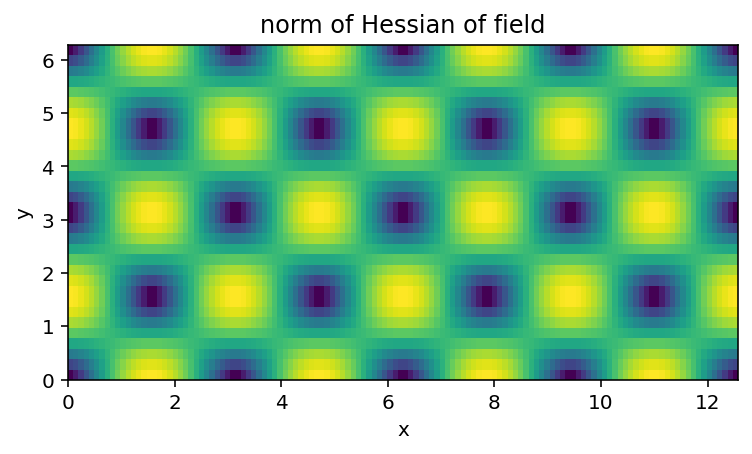

In [30]:
field_hess.plot();

Vector and tensor fields can also be used in dot products, either via the `.dot()` method or using the `@` notation denoting matrix products in in python.

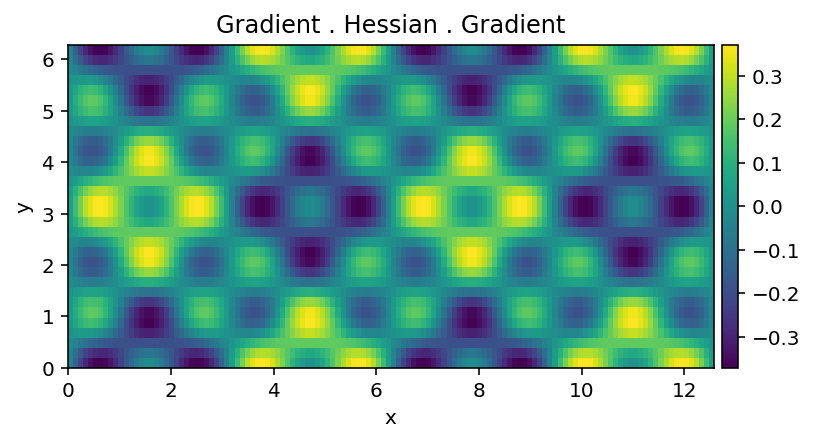

In [31]:
scalar_field = field_grad @ field_hess @ field_grad
scalar_field.plot(title='Gradient . Hessian . Gradient', colorbar=True);

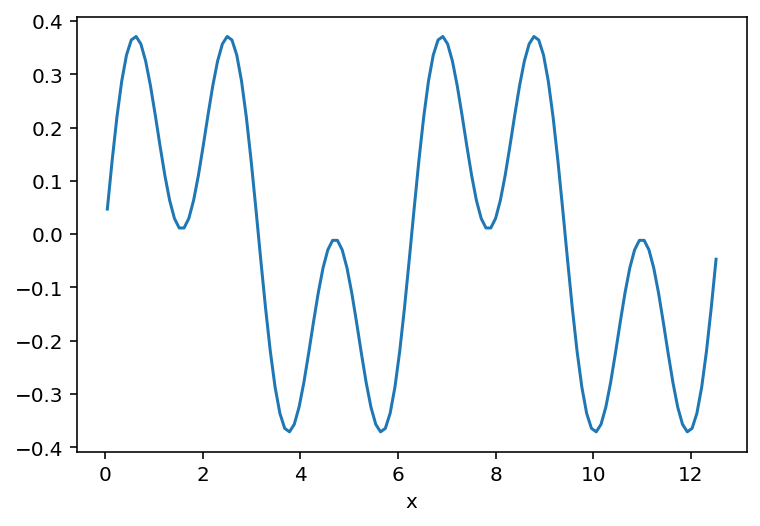

In [32]:
scalar_field.slice({'y': np.pi}).plot();

## Field collections
Many partial differential equations combine several fields, which can be represented as a collection.

In [33]:
grid_pol = pde.PolarGrid([2, 7], 32)
scalar_field1 = pde.ScalarField.from_expression(grid_pol, 'r**2', label='Increasing')
scalar_field2 = pde.ScalarField.from_expression(grid_pol, '1/r', label='Decreasing')
collection = pde.FieldCollection([scalar_field1, scalar_field2])
collection.attributes

{'class': 'FieldCollection',
 'label': None,
 'fields': [{'class': 'ScalarField',
   'grid': PolarGrid(radius=(2, 7), shape=(32,)),
   'label': 'Increasing'},
  {'class': 'ScalarField',
   'grid': PolarGrid(radius=(2, 7), shape=(32,)),
   'label': 'Decreasing'}]}

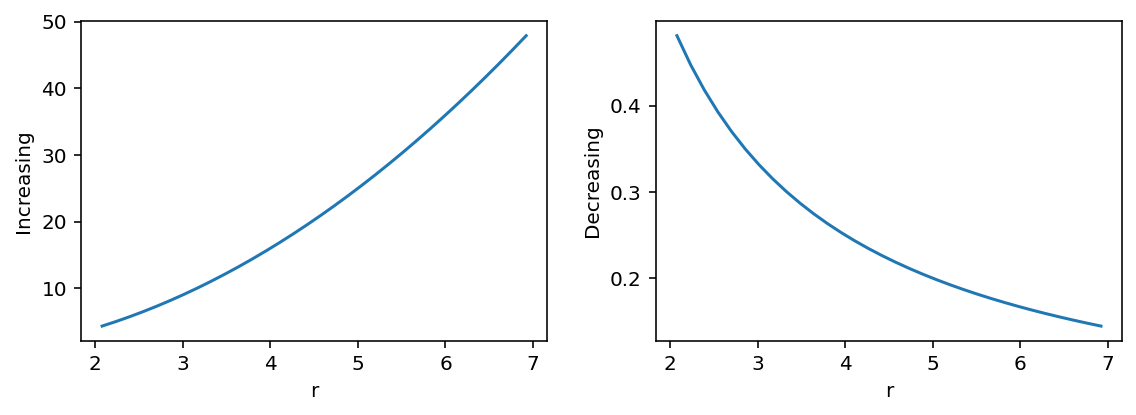

In [34]:
collection.plot()

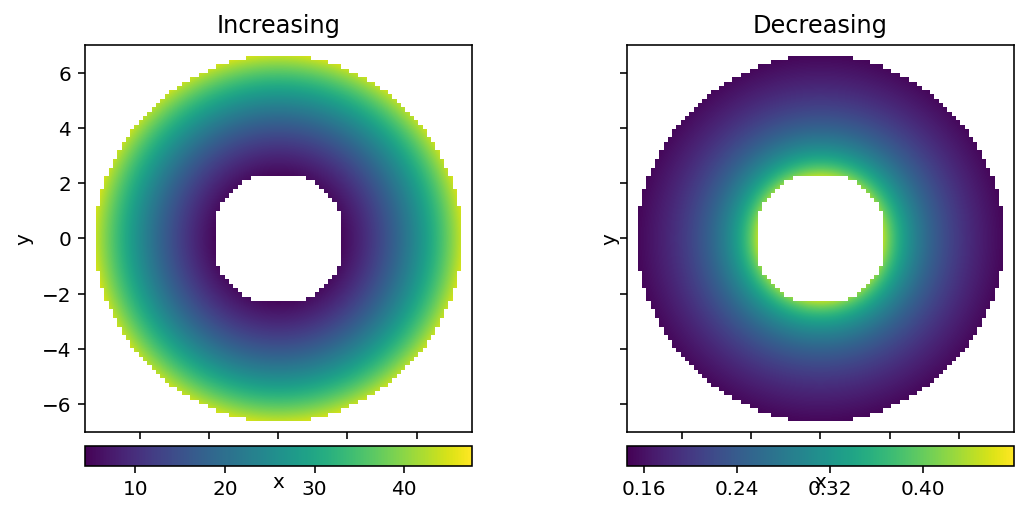

In [35]:
collection.plot_image()

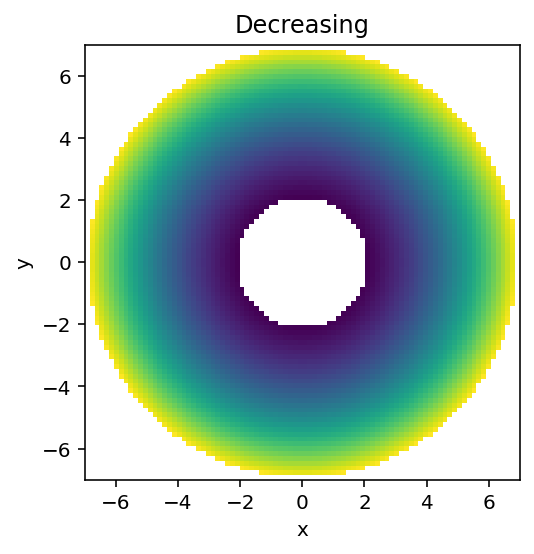

In [36]:
(collection[0] + collection[1]).plot_image();

In [37]:
grid = pde.UnitGrid([96, 64])
sf = pde.ScalarField.random_colored(grid, exponent=-3)
vf = pde.VectorField.random_harmonic(grid, modes=1)
fc = pde.FieldCollection([sf, vf])

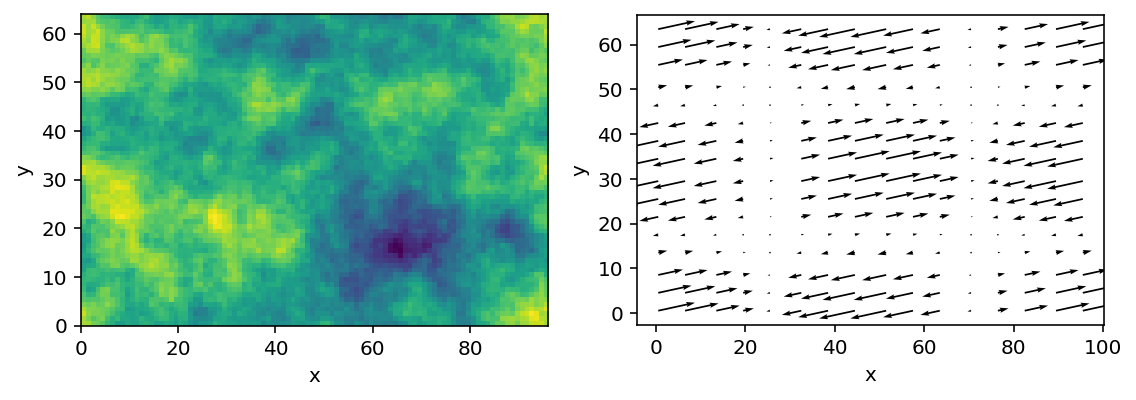

In [38]:
fc.plot()